# Model exploration, checking, and comparison

An important goal of creating PyEI was to facilitate the exploration, evaluation, and comparison of models for ecological inference. We wanted to make it easier to perform the kinds of checks that are typically part of a Bayesian workflow, such as prior predictive checks, posterior predictive checks, diagnostics checks for the samples, etc. This notebooks is a work in progress, meant to demonstrate some ways to use pyei to better understand the underlying models. We briefly show examples of:

- loading example data
- setting up the model
- sampling from and inspecting the prior predictive distribution
- fitting the model and generating posterior samples
- Using Arviz to inspect traceplots, report convergence diagnostics like effective sample size and rhat, and compare prior and posterior distributions

Much of this functionality comes from 1) PyEI's reliance of pymc3 and 2) using ArviZ for exploratory analysis. The documentation for these libraries are a helpful resource.

In [3]:
import numpy as np
import pymc as pm
from matplotlib import pyplot as plt
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER, GoodmansERBayes
from pyei.data import Datasets

### Load some example data

In [4]:
# Load example data
data = Datasets.Santa_Clara.to_dataframe()
X = np.array(data["pct_e_asian_vote"])
T = np.array(data["pct_for_hardy2"])
N = np.array(data["total2"])
demographic_group_name = "e_asian"
candidate_name="Hardy"
precinct_names = data['precinct']

### Set up the model

In [5]:
ei = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)

# NOTE: the fit function is the easiest way to set the model (ei.sim_model), which we need for the prior predictive
# But, we of course don't use the draws from the posterior in the prior predictive checks!
# Note that the prior predictive draws of votes_count *DO* depend on precinct_pops and demographic_group_fractions
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, draw_samples=False)


### Sample from the prior predictive distribution

In [6]:
# Sample from the prior predictive distributions
with ei.sim_model as sim_model:
    idata = pm.sample_prior_predictive(10000) # creates an InferenceData object

In [7]:
### Examine the prior predictive distribution

In [9]:
# A list of the named random variables in the model (so that we know what we can examine)
pm.util.get_default_varnames(ei.sim_model.named_vars, include_transformed=False)

['phi_1', 'kappa_1', 'phi_2', 'kappa_2', 'b_1', 'b_2', 'votes_count']

In [22]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [24]:
idata['prior_predictive']['votes_count'].values.shape # number of prior predictive draws x num_precincts

(1, 10000, 42)

(array([1131.,  999.,  971.,  927.,  956.,  972.,  979.,  948.,  993.,
        1124.]),
 array([  0. ,  65.8, 131.6, 197.4, 263.2, 329. , 394.8, 460.6, 526.4,
        592.2, 658. ]),
 <BarContainer object of 10 artists>)

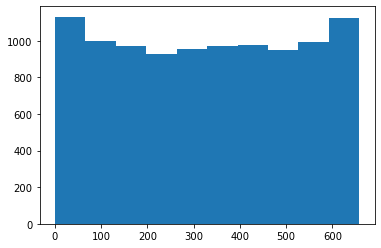

In [28]:
# plot a histogram of the prior predictive draws of the count of votes in the 0'th county
plt.hist(idata['prior_predictive']['votes_count'].values[0,:,0])

(array([1360.,  956.,  925.,  950.,  893.,  851.,  923.,  929.,  908.,
        1305.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

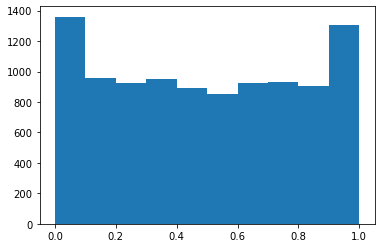

In [29]:
plt.hist(idata['prior']['b_1'][0,:,0]) #0th chain, 0th precinct

(array([1333.,  925.,  933.,  901.,  893.,  919.,  955.,  916.,  886.,
        1339.]),
 array([1.89857114e-138, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <BarContainer object of 10 artists>)

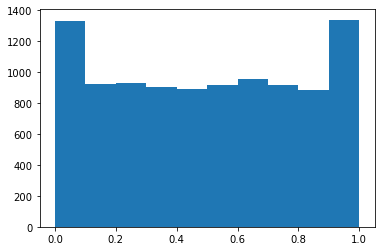

In [30]:
plt.hist(idata['prior']['b_2'][0,:,0])

(array([1037., 1068.,  958., 1014.,  980.,  986.,  978.,  987., 1014.,
         978.]),
 array([5.99275700e-05, 1.00045570e-01, 2.00031212e-01, 3.00016854e-01,
        4.00002496e-01, 4.99988139e-01, 5.99973781e-01, 6.99959423e-01,
        7.99945065e-01, 8.99930707e-01, 9.99916350e-01]),
 <BarContainer object of 10 artists>)

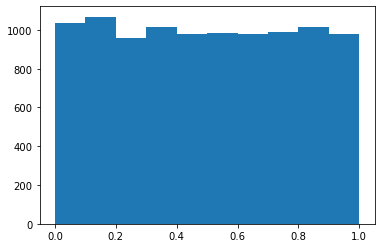

In [31]:
plt.hist(idata['prior']['phi_1'][0,:])

(array([1007.,  962., 1025., 1001., 1044.,  985., 1001.,  965.,  987.,
        1023.]),
 array([8.33260684e-07, 1.00000749e-01, 2.00000665e-01, 3.00000580e-01,
        4.00000496e-01, 5.00000412e-01, 6.00000328e-01, 7.00000243e-01,
        8.00000159e-01, 9.00000075e-01, 9.99999990e-01]),
 <BarContainer object of 10 artists>)

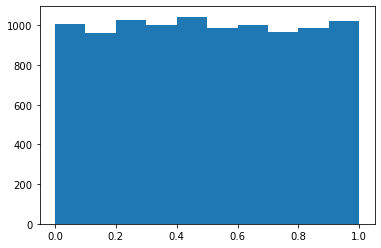

In [34]:
# We can weight by population and obtain district-level voting preferences 
# from the prior predictive samples, if desired

samples_converted_to_pops_gp1 = (
    idata["prior"]["b_1"].stack(all_draws=["chain", "draw"]).values.T
    * N
)  # shape: num_samples x num_precincts
samples_converted_to_pops_gp2 = (
    idata["prior"]["b_2"].stack(all_draws=["chain", "draw"]).values.T
    * N
)  # shape: num_samples x num_precincts

# obtain samples of total votes summed across all precinct for the candidate for each group
samples_of_votes_summed_across_district_gp1 = samples_converted_to_pops_gp1.sum(axis=1)
samples_of_votes_summed_across_district_gp2 = samples_converted_to_pops_gp2.sum(axis=1)

# obtain samples of the districtwide proportion of each demog. group voting for candidate
sampled_voting_prefs_gp2 = (
    samples_of_votes_summed_across_district_gp1 / N.sum()
)  # sampled voted prefs across precincts
sampled_voting_prefs_gp1 = (
    samples_of_votes_summed_across_district_gp2 / N.sum()
        )  # sampled voted prefs across precincts
# We can explore a histogram of these district-level voting preferences:
plt.hist(sampled_voting_prefs_gp1)

(array([ 204.,  570., 1010., 1315., 1783., 1757., 1411., 1023.,  656.,
         271.]),
 array([-0.99175428, -0.79551757, -0.59928086, -0.40304415, -0.20680744,
        -0.01057072,  0.18566599,  0.3819027 ,  0.57813941,  0.77437612,
         0.97061283]),
 <BarContainer object of 10 artists>)

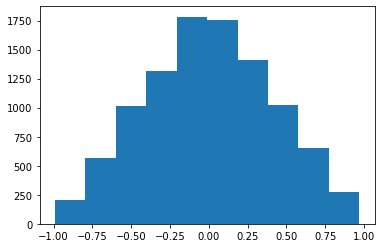

In [35]:
# Here we consider the differences in the voting preferences between the two groups, 
# as sampled from the prior predictive
plt.hist(sampled_voting_prefs_gp1 - sampled_voting_prefs_gp2)

In [36]:
# We can probe, e.g., what percentage of samples from the prior predictive l
# ook polarized according to this measure
(abs(sampled_voting_prefs_gp1 - sampled_voting_prefs_gp2) > 0.1).sum() / len(sampled_voting_prefs_gp1)


0.8069

### Fitting the model and generating posterior samples

In [38]:
## Fitting the model
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, tune=3000)

Compiling...


/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:04.346943
Sampling...


Compiling.. :   0%|                                                       | 0/4000 [00:00<?, ?it/s]

  0%|                                                                     | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                       | 0/4000 [00:00<?, ?it/s]


  0%|                                                                     | 0/4000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                    | 0/4000 [00:14<?, ?it/s]

Running chain 2:   0%|                                                    | 0/4000 [00:14<?, ?it/s]


Running chain 0:   0%|                                                    | 0/4000 [00:14<?, ?it/s]

Running chain 1:   5%|██                                       | 200/4000 [00:15<00:18, 204.08it/s]


Running chain 1:  10%|████                                     | 400/4000 [00:16<00:10, 359.19it/s]

Running chain 2:  10%|████                                     | 400/4000 [00:16<00:11,

Sampling time =  0:00:24.809691
Transforming variables...
Transformation time =  0:00:00.176812


### Sample from the posterior predictive

In [40]:
with ei.sim_model as sim_model:
    posterior_pred = pm.sample_posterior_predictive(ei.sim_trace)
posterior_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

(array([  5.,  18.,  50., 149., 203., 274., 179.,  80.,  34.,   8.]),
 array([114. , 123.6, 133.2, 142.8, 152.4, 162. , 171.6, 181.2, 190.8,
        200.4, 210. ]),
 <BarContainer object of 10 artists>)

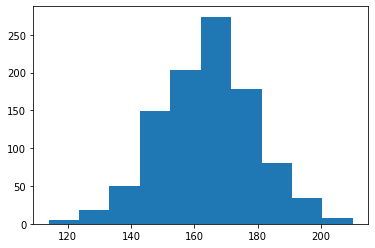

In [43]:
plt.hist(posterior_pred['posterior_predictive']['votes_count'][0,:,0]) # Simulated vote counts for the 0th county

# Using arviz to explore the model:

Pyei works well with arviz, a library for exploratory analysis of bayesian models.


### We'll use the outputs of pyei and pymc and will create a data inference object that has prior predictive, posterior, and posterior predictive distributions all contained within it. 

In [47]:
# with arviz
# data = az.from_pymc3(
#     posterior=ei.sim_trace, #the posterior distribution
#     prior=idata['prior_predictive'],
#     posterior_predictive=posterior_pred['posterior_predictive'],
#     model=ei.sim_model,
# )
# data

### We can look at some convergence diagnostics like rhat and the effective sample size for each variable

In [48]:
az.ess(ei.sim_trace)

<xarray.Dataset>
Dimensions:    (b_1_dim_0: 42, b_2_dim_0: 42)
Coordinates:
  * b_1_dim_0  (b_1_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * b_2_dim_0  (b_2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
Data variables:
    phi_1      float64 91.95
    kappa_1    float64 628.7
    phi_2      float64 87.15
    kappa_2    float64 902.8
    b_1        (b_1_dim_0) float64 207.2 188.0 179.1 177.3 ... 300.1 188.4 169.7
    b_2        (b_2_dim_0) float64 680.8 522.3 396.2 453.5 ... 341.8 453.5 493.8

In [49]:
az.rhat(ei.sim_trace)

<xarray.Dataset>
Dimensions:    (b_1_dim_0: 42, b_2_dim_0: 42)
Coordinates:
  * b_1_dim_0  (b_1_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * b_2_dim_0  (b_2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
Data variables:
    phi_1      float64 1.055
    kappa_1    float64 1.01
    phi_2      float64 1.047
    kappa_2    float64 1.006
    b_1        (b_1_dim_0) float64 1.023 1.026 1.029 1.028 ... 1.021 1.026 1.028
    b_2        (b_2_dim_0) float64 1.007 1.011 1.016 1.012 ... 1.018 1.013 1.011

### Traceplots

array([[<AxesSubplot:title={'center':'phi_1'}>,
        <AxesSubplot:title={'center':'phi_1'}>],
       [<AxesSubplot:title={'center':'kappa_1'}>,
        <AxesSubplot:title={'center':'kappa_1'}>],
       [<AxesSubplot:title={'center':'phi_2'}>,
        <AxesSubplot:title={'center':'phi_2'}>],
       [<AxesSubplot:title={'center':'kappa_2'}>,
        <AxesSubplot:title={'center':'kappa_2'}>],
       [<AxesSubplot:title={'center':'b_1'}>,
        <AxesSubplot:title={'center':'b_1'}>],
       [<AxesSubplot:title={'center':'b_2'}>,
        <AxesSubplot:title={'center':'b_2'}>]], dtype=object)

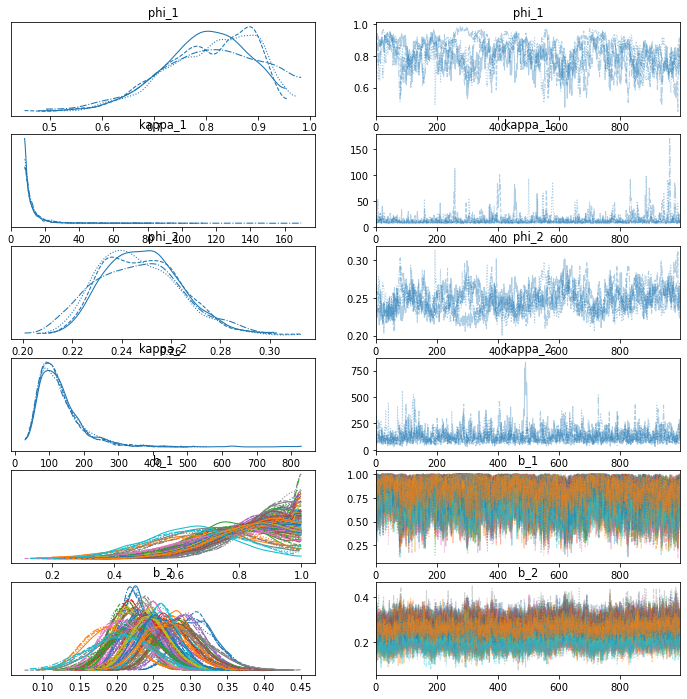

In [50]:
az.plot_trace(ei.sim_trace, compact=True)
# each color here is a different chain, vertical tick marks mark divergences
# Set compact = False to see each county on a different plot

<AxesSubplot:xlabel='votes_count / votes_count'>

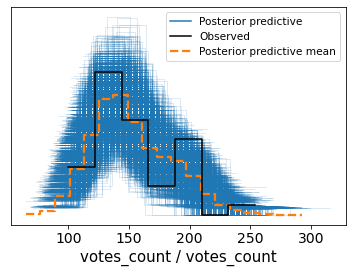

In [52]:
## We can look at posterior predictive draws
az.plot_ppc(posterior_pred)

### We can compare prior and posterior distributions of variables of interest

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

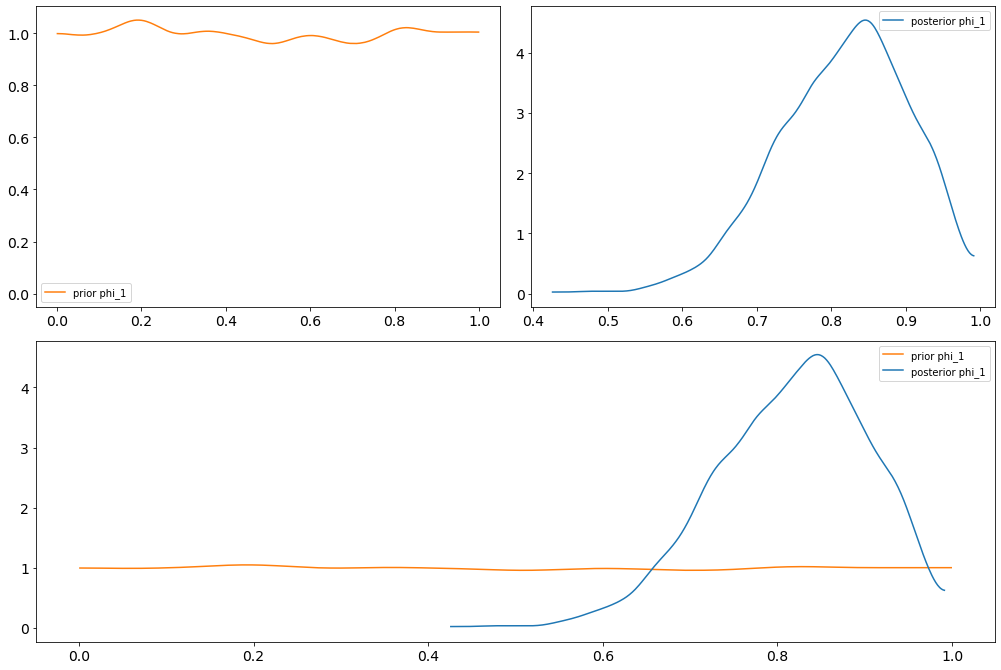

In [40]:
az.plot_dist_comparison(data, var_names='phi_1')

In [41]:
#az.plot_dist_comparison(data, var_names='b_2')

In [42]:
#data.posterior['voting_prefs_gp1'] =  ei.sampled_voting_prefs[0]

In [43]:
#data.posterior['voting_prefs_gp2'] =  ei.sampled_voting_prefs[1]

In [44]:
#az.plot_dist(data.posterior['voting_prefs_gp1'])

### Draws from the prior predictive distribution are one source of simulated data on which we can test our model


Note that the prior predictive distribution will use the precinct populations (here, N) and the group fractions (here X) in generating the vote counts for each county. Here we'll come up with fictional X and N before we use them to generate the votes.

This is a generous-to-the-model way to make fake data for our model -- since the data comes from the generative model itself! We also want to think about what happens if the data in the real world doesn't look much like data from the generative model.

In [53]:
num_precincts = 10
X = np.linspace(0.1, 0.9, num_precincts)
N = 100 * np.ones(num_precincts)
T = 50 * np.ones(num_precincts) / N #ei.fit needs a vote_counts, value, even though this won't get used in the prior predictive

In [60]:
# Sample from the prior predictive
ei.fit(X, T, N, draw_samples=False)
with ei.sim_model as model:
    prior_pred_for_simulation = pm.sample_prior_predictive()

In [63]:
# Use one of the prior predictive samples as simulated data
sample_num = 0
simulated_vote_fraction = prior_pred_for_simulation['prior_predictive']['votes_count'].values[0,sample_num,:] / N
simulated_vote_fraction

array([0.4 , 0.68, 0.45, 0.49, 0.62, 0.31, 0.69, 0.14, 0.42, 0.21])

In [65]:
ei.fit(X, simulated_vote_fraction, N)

Compiling...


/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:04.263724
Sampling...


Compiling.. :   0%|                                                       | 0/2500 [00:00<?, ?it/s]

  0%|                                                                     | 0/2500 [00:00<?, ?it/s]

Compiling.. :   0%|                                                       | 0/2500 [00:00<?, ?it/s]


  0%|                                                                     | 0/2500 [00:00<?, ?it/s]


Running chain 1:   0%|                                                    | 0/2500 [00:11<?, ?it/s]


Running chain 3:   0%|                                                    | 0/2500 [00:11<?, ?it/s]

Running chain 1:   5%|██                                      | 125/2500 [00:11<00:02, 1183.25it/s]


Running chain 0:  10%|████                                    | 250/2500 [00:11<00:01, 1796.22it/s]

Running chain 1:  20%|████████                                | 500/2500 [00:12<00:00, 2219.91it/s]

Running chain 0:  25%|██████████                              | 625/2500 [00:12<00:00, 

Sampling time =  0:00:14.018543
Transforming variables...
Transformation time =  0:00:00.185133


(<AxesSubplot:xlabel='Support for given candidate'>,
 <AxesSubplot:title={'center':'EI Summary'}>)

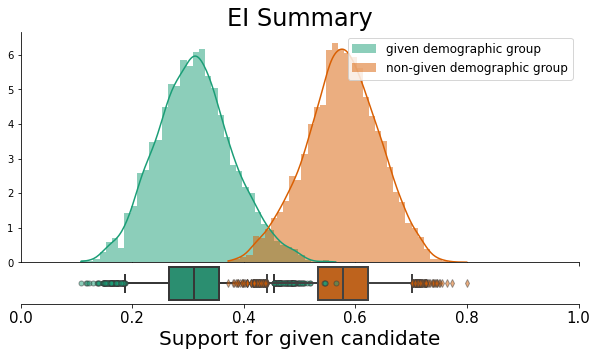

In [67]:
ei.plot()

In [68]:
# compute true district-level voting preferences
voting_pref_gp1 = (prior_pred_for_simulation['prior']['b_1'][0,sample_num,:] * N).sum() / N.sum()
voting_pref_gp2 = (prior_pred_for_simulation['prior']['b_2'][0,sample_num,:] * N).sum() / N.sum()

In [72]:
print(ei.summary())
print("true values:", voting_pref_gp1.values, voting_pref_gp2.values)

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        given demographic group for given candidate is
        0.312
        The posterior mean for the district-level voting preference of
        non-given demographic group for given candidate is
        0.576
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        given demographic group for given candidate is
        [0.18644538 0.45425549]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-given demographic group for given candidate is
        [0.44178501 0.70193284]
        
true values: 0.3307041382294177 0.6264206059156274


In [74]:
# we can compare the inferred betas to the actual ones
prior_pred_for_simulation['prior']['b_1'][0,sample_num,:] #actual
precinct_posterior_means, precinct_credible_intervals = ei.precinct_level_estimates() # inferred
b_1_posterior_means = precinct_posterior_means[:,0, 0]
b_2_posterior_means = precinct_posterior_means[:,1, 0]
b_1_credible_ints = precinct_credible_intervals[:, 0, 0, :]
b_2_credible_ints = precinct_credible_intervals[:, 1, 0, :]

b_1_int_lower = [x[0] for x in b_1_credible_ints]
b_1_int_upper = [x[1] for x in b_1_credible_ints]
b_2_int_lower = [x[0] for x in b_2_credible_ints]
b_2_int_upper = [x[1] for x in b_2_credible_ints]
import pandas as pd
df_b1 = pd.DataFrame({'actual': prior_pred_for_simulation['prior']['b_1'][0,sample_num,:], 'inferred': b_1_posterior_means, '95% CI lower':b_1_int_lower, '95% CI upper':b_1_int_upper})
df_b2 = pd.DataFrame({'actual': prior_pred_for_simulation['prior']['b_2'][0,sample_num,:], 'inferred': b_2_posterior_means, '95% CI lower':b_2_int_lower, '95% CI upper':b_2_int_upper})
df_b1

,actual,inferred,95% CI lower,95% CI upper
0,0.459735,0.289624,0.046509,0.634498
1,0.426647,0.340791,0.051523,0.693895
2,0.391560,0.285128,0.040398,0.634832
3,0.150013,0.304015,0.049136,0.636519
4,0.515927,0.437640,0.148943,0.739348
5,0.050121,0.205443,0.037688,0.431972
6,0.639518,0.609708,0.421691,0.800909
7,0.078026,0.097811,0.014676,0.210281
8,0.414379,0.366381,0.232744,0.507241
9,0.181114,0.184530,0.095820,0.280126


Text(0.5, 1.0, 'county level actual and estimate support of group 1 for candidate 1')

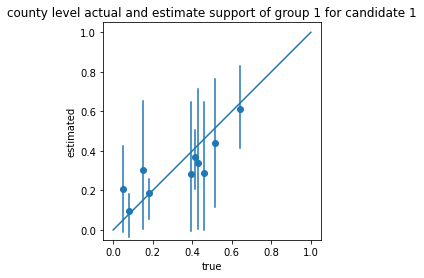

In [75]:
from matplotlib import pyplot as plt
plt.scatter(df_b1['actual'], df_b1['inferred'])
for true_val, cred_int in zip(df_b1['actual'], b_1_credible_ints):
    plt.axvline(x=true_val, ymin=cred_int[0], ymax=cred_int[1])
plt.plot((0,1), (0,1))
plt.axis('square')
plt.xlabel('true')
plt.ylabel('estimated')
plt.title("county level actual and estimate support of group 1 for candidate 1")

Text(0.5, 1.0, 'county level actual and estimate support of group 2 for candidate 2')

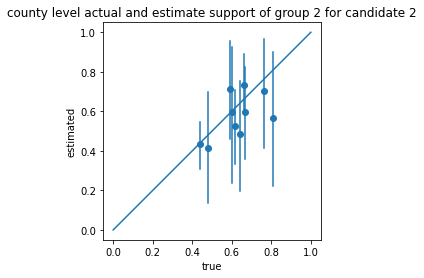

In [76]:
from matplotlib import pyplot as plt
plt.scatter(df_b2['actual'], df_b2['inferred'])
for true_val, cred_int in zip(df_b2['actual'], b_2_credible_ints):
    plt.axvline(x=true_val, ymin=cred_int[0], ymax=cred_int[1])
plt.plot((0,1), (0,1))
plt.axis('square')
plt.xlabel('true')
plt.ylabel('estimated')
plt.title("county level actual and estimate support of group 2 for candidate 2")

<AxesSubplot:title={'center':'Precinct level estimates of voting preferences'}, xlabel='Percent vote for candidate', ylabel='Precinct'>

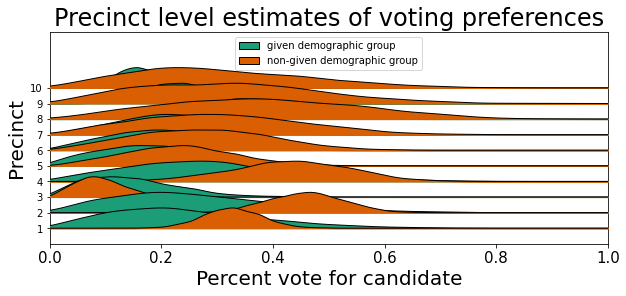

In [63]:
ei.precinct_level_plot()